In [1]:
image_paths = {
    "2018": {
        "image": "refined_dataset/images/image_2018.jpg",
        "masks": "refined_dataset/masks/mask_2018.png"
    },
    "2020": {
        "image": "refined_dataset/images/image_2020.jpg",
        "masks": "refined_dataset/masks/mask_2020.png"
    },
    "2022": {
        "image": "refined_dataset/images/image_2022.jpg",
        "masks": "refined_dataset/masks/mask_2020.png"
    }
}

In [2]:
import matplotlib.pyplot as plt

In [3]:
import rasterio
from rasterio.plot import reshape_as_image

with rasterio.open(image_paths["2018"]["image"]) as src:
    image = reshape_as_image(src.read())
    print(f'Image shape: {image.shape}')  # (height, width, bands)

/home/acharyp/anaconda3/envs/remote_sensing_change_detection/lib/python3.12/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Image shape: (12210, 9610, 3)


In [4]:
with rasterio.open(image_paths["2018"]["masks"]) as src:
    labels = reshape_as_image(src.read())
    print(f'Labels shape: {labels.shape}')  # (height, width, channels)

Labels shape: (12210, 9610, 3)


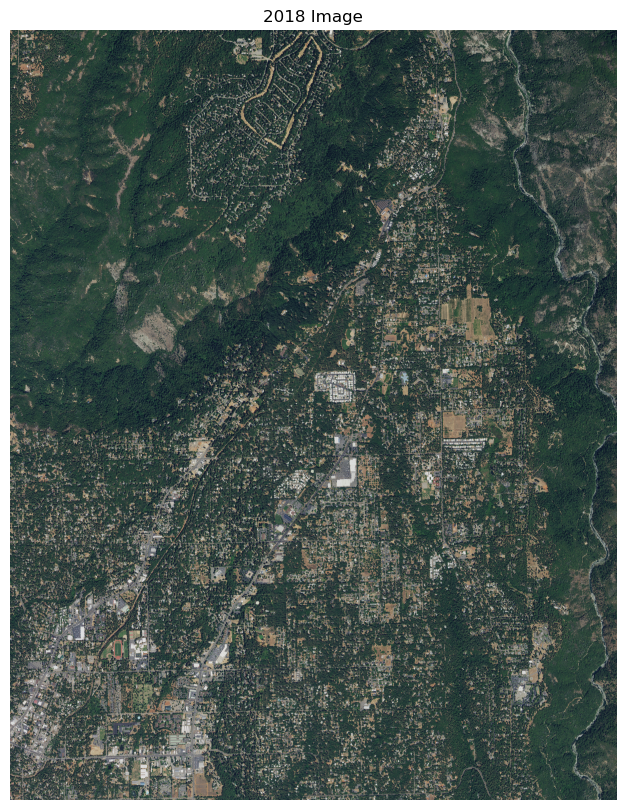

In [5]:
plt.figure(figsize=(10,10))
plt.imshow(image)
plt.title('2018 Image')
plt.axis('off')
plt.show()

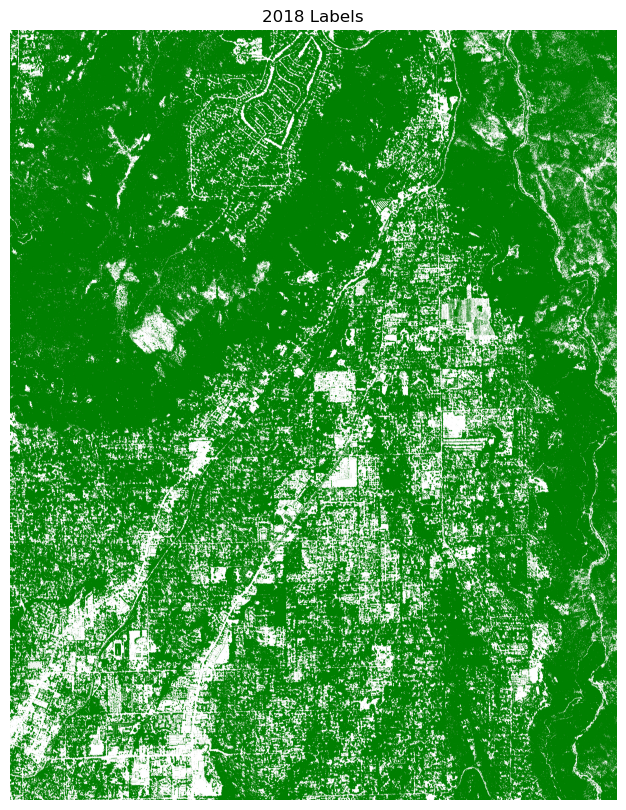

In [6]:
plt.figure(figsize=(10,10))
plt.imshow(labels)
plt.title('2018 Labels')
plt.axis('off')
plt.show()

In [7]:
import numpy as np
from sklearn.preprocessing import LabelEncoder

color_to_class = {
    (0, 128, 1): 'forest',
    (255, 255, 255): 'not forest'
}

def rgb_to_class(rgb):
    return color_to_class.get(tuple(rgb), 'not forest')

classes = np.apply_along_axis(rgb_to_class, 2, labels)

# Encode class labels
le = LabelEncoder()
y = le.fit_transform(classes.flatten())
print(f'Number of classes: {len(le.classes_)}')

Number of classes: 2


In [8]:
pixels = image.reshape((-1, image.shape[2]))

mask = y != le.transform(['not forest'])[0]
pixels = pixels[mask]
y = y[mask]
print(f'Pixels shape after masking: {pixels.shape}')

Pixels shape after masking: (51195700, 3)


In [9]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X = scaler.fit_transform(pixels)

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print(f'Training samples: {X_train.shape[0]}, Testing samples: {X_test.shape[0]}')

Training samples: 40956560, Testing samples: 10239140


In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, n_jobs=-1)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)